In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import datetime
import argparse

from azureml.core.run import Run
from azureml.core import Workspace, Dataset
from tf_agents.environments import tf_py_environment, py_environment, utils
from tf_agents.networks import sequential
from tf_agents.agents.dqn import dqn_agent
from tf_agents.policies import EpsilonGreedyPolicy, random_tf_policy
from tf_agents.policies.q_policy import QPolicy
from tf_agents.policies.boltzmann_policy import BoltzmannPolicy
from tf_agents.trajectories import trajectory, Trajectory, PolicyStep, time_step as ts
from tf_agents.replay_buffers import TFUniformReplayBuffer
from tf_agents.metrics import tf_metrics
from tf_agents.specs import array_spec
from tf_agents.drivers import dynamic_step_driver
from tf_agents.utils import common
from keras.layers import Input, Dense, Activation, BatchNormalization, Dropout
# from helper_functions import *
# from environment_functions import *

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
class DynamicPricingCompetition():
    
    """
    A game object where the agent can interact with and that we can update remotely
    to adjust the current state based on recent observations.
    This class also keeps track of all the steps and rewards that took place for later analysis.
    """
    
    def __init__(self):
        self.selling_period = 1
        self.loadfactor = 0
        self.competitor_has_capacity = 1
        self.price_competitor_t1 = 50
        self.price_competitor_t2 = 50
        self.price_competitor_t3 = 50
        self.price_competitor_t4 = 50
        self.price_competitor_t5 = 50
        self.price_competitor_t6 = 50
        self.price_competitor_t7 = 50
        self.price_competitor_t8 = 50
        self.price_competitor_t9 = 50
        self.price_competitor_t10 = 50
        self.price_t1 = 50
        self.price_t2 = 50
        self.price_t3 = 50
        self.price_t4 = 50
        self.price_t5 = 50
        self.price_t6 = 50
        self.price_t7 = 50
        self.price_t8 = 50
        self.price_t9 = 50
        self.price_t10 = 50
        self.demand_t1 = 0
        self.demand_t2 = 0
        self.demand_t3 = 0
        self.demand_t4 = 0
        self.demand_t5 = 0
        self.demand_t6 = 0
        self.demand_t7 = 0
        self.demand_t8 = 0
        self.demand_t9 = 0
        self.demand_t10 = 0
        self.competition_results_df = pd.DataFrame(columns=[
            'our_strategy',
            'competition_id',
            'selling_season', 
            'selling_period', 
            'competitor_id', 
            'price_competitor', 
            'price', 
            'demand', 
            'competitor_has_capacity', 
            'revenue'
        ])
        
        self.state = [
            self.selling_period,
            self.loadfactor,
            self.competitor_has_capacity,
            self.price_competitor_t1,
            self.price_competitor_t2,
            self.price_competitor_t3,
            self.price_competitor_t4,
            self.price_competitor_t5,
            self.price_competitor_t6,
            self.price_competitor_t7,
            self.price_competitor_t8,
            self.price_competitor_t9,
            self.price_competitor_t10,
            self.price_t1,
            self.price_t2,
            self.price_t3,
            self.price_t4,
            self.price_t5,
            self.price_t6,
            self.price_t7,
            self.price_t8,
            self.price_t9,
            self.price_t10,
            self.demand_t1,
            self.demand_t2,
            self.demand_t3,
            self.demand_t4,
            self.demand_t5,
            self.demand_t6,
            self.demand_t7,
            self.demand_t8,
            self.demand_t9,
            self.demand_t10,
        ]
        self._reward = 0
        
    def reset(self):
        self.selling_period = 1
        self.loadfactor = 0
        self.competitor_has_capacity = 1
        self.price_competitor_t1 = 50
        self.price_competitor_t2 = 50
        self.price_competitor_t3 = 50
        self.price_competitor_t4 = 50
        self.price_competitor_t5 = 50
        self.price_competitor_t6 = 50
        self.price_competitor_t7 = 50
        self.price_competitor_t8 = 50
        self.price_competitor_t9 = 50
        self.price_competitor_t10 = 50
        self.price_t1 = 50
        self.price_t2 = 50
        self.price_t3 = 50
        self.price_t4 = 50
        self.price_t5 = 50
        self.price_t6 = 50
        self.price_t7 = 50
        self.price_t8 = 50
        self.price_t9 = 50
        self.price_t10 = 50
        self.demand_t1 = 0
        self.demand_t2 = 0
        self.demand_t3 = 0
        self.demand_t4 = 0
        self.demand_t5 = 0
        self.demand_t6 = 0
        self.demand_t7 = 0
        self.demand_t8 = 0
        self.demand_t9 = 0
        self.demand_t10 = 0
        
        self.state = [
            self.selling_period,
            self.loadfactor,
            self.competitor_has_capacity,
            self.price_competitor_t1,
            self.price_competitor_t2,
            self.price_competitor_t3,
            self.price_competitor_t4,
            self.price_competitor_t5,
            self.price_competitor_t6,
            self.price_competitor_t7,
            self.price_competitor_t8,
            self.price_competitor_t9,
            self.price_competitor_t10,
            self.price_t1,
            self.price_t2,
            self.price_t3,
            self.price_t4,
            self.price_t5,
            self.price_t6,
            self.price_t7,
            self.price_t8,
            self.price_t9,
            self.price_t10,
            self.demand_t1,
            self.demand_t2,
            self.demand_t3,
            self.demand_t4,
            self.demand_t5,
            self.demand_t6,
            self.demand_t7,
            self.demand_t8,
            self.demand_t9,
            self.demand_t10,
        ]
        self._reward = 0
        
    def update_state(self, vars_dict):
        self.selling_period = vars_dict['selling_period']
        self.loadfactor = vars_dict['loadfactor']
        self.competitor_has_capacity = vars_dict['competitor_has_capacity']
        self.price_competitor_t1 = vars_dict['price_competitor_t-1']
        self.price_competitor_t2 = vars_dict['price_competitor_t-2']
        self.price_competitor_t3 = vars_dict['price_competitor_t-3']
        self.price_competitor_t4 = vars_dict['price_competitor_t-4']
        self.price_competitor_t5 = vars_dict['price_competitor_t-5']
        self.price_competitor_t6 = vars_dict['price_competitor_t-6']
        self.price_competitor_t7 = vars_dict['price_competitor_t-7']
        self.price_competitor_t8 = vars_dict['price_competitor_t-8']
        self.price_competitor_t9 = vars_dict['price_competitor_t-9']
        self.price_competitor_t10 = vars_dict['price_competitor_t-10']
        self.price_t1 = vars_dict['price_t-1']
        self.price_t2 = vars_dict['price_t-2']
        self.price_t3 = vars_dict['price_t-3']
        self.price_t4 = vars_dict['price_t-4']
        self.price_t5 = vars_dict['price_t-5']
        self.price_t6 = vars_dict['price_t-6']
        self.price_t7 = vars_dict['price_t-7']
        self.price_t8 = vars_dict['price_t-8']
        self.price_t9 = vars_dict['price_t-9']
        self.price_t10 = vars_dict['price_t-10']
        self.demand_t1 = vars_dict['demand_t-1']
        self.demand_t2 = vars_dict['demand_t-2']
        self.demand_t3 = vars_dict['demand_t-3']
        self.demand_t4 = vars_dict['demand_t-4']
        self.demand_t5 = vars_dict['demand_t-5']
        self.demand_t6 = vars_dict['demand_t-6']
        self.demand_t7 = vars_dict['demand_t-7']
        self.demand_t8 = vars_dict['demand_t-8']
        self.demand_t9 = vars_dict['demand_t-9']
        self.demand_t10 = vars_dict['demand_t-10']
        
        self.state = [
            self.selling_period,
            self.loadfactor,
            self.competitor_has_capacity,
            self.price_competitor_t1,
            self.price_competitor_t2,
            self.price_competitor_t3,
            self.price_competitor_t4,
            self.price_competitor_t5,
            self.price_competitor_t6,
            self.price_competitor_t7,
            self.price_competitor_t8,
            self.price_competitor_t9,
            self.price_competitor_t10,
            self.price_t1,
            self.price_t2,
            self.price_t3,
            self.price_t4,
            self.price_t5,
            self.price_t6,
            self.price_t7,
            self.price_t8,
            self.price_t9,
            self.price_t10,
            self.demand_t1,
            self.demand_t2,
            self.demand_t3,
            self.demand_t4,
            self.demand_t5,
            self.demand_t6,
            self.demand_t7,
            self.demand_t8,
            self.demand_t9,
            self.demand_t10,
        ]
        self._reward = 0
        
    def update_reward(self, reward):
        self.reward = reward
        
        
# Environment in which the agent operates in, and is protected from altering
class AirlineEnvironment(py_environment.PyEnvironment):
    
    def __init__(self, dpc_game, simulator, num_features, num_actions, discount, min_action, 
                 action_step, comp_sellout_price, early_termination_penalty=0, price_diff_penalty=0, 
                 stock_remainder_penalty=0):
        """
        Initialize what actions the agent can take,
        and what the observation space will look like.
        
        Also initialize the environment where the agent will interact with.
        """
        self._action_spec = array_spec.BoundedArraySpec(
            shape=(), dtype=np.int32, minimum=0, maximum=num_actions-1, name='action'
        )
        self._observation_spec = array_spec.BoundedArraySpec(
            shape=(num_features,), dtype=np.int32, name='observation'
        )
        self._selling_season = 1
        self._episode_ended = False
        self._discount = discount
        self._dpc_game = dpc_game
        self._simulator = simulator
        self._comp_strat = np.random.choice(
            [
                "random_ranges", 
                "highstart_randomranges", 
                "follower_strategy"
            ]
        )
        self._comp_strategy = CompStrategySimulation(self._comp_strat)
        self._min_action = min_action
        self._action_step = action_step
        self._comp_sellout_price = comp_sellout_price
        self._early_termination_penalty = early_termination_penalty
        self._price_diff_penalty = price_diff_penalty
        self._stock_remainder_penalty = stock_remainder_penalty
        self._our_price = 50
        self._comp_price = 50
        self._last_comp_price = [0]
        self._all_demand = []
        
    def action_spec(self):
        return self._action_spec

    def observation_spec(self):
        return self._observation_spec
    
    def current_time_step(self):
        return self._current_time_step

    def reset(self):
        self._current_time_step = self._reset()
        return self._current_time_step

    def step(self, action):
        self._current_time_step = self._step(action)
        return self._current_time_step

    def _reset(self):
        self._episode_ended = False
        self._selling_season += 1
        self._dpc_game.reset()
        self._simulator.reset_environment()
        self._comp_strat = np.random.choice(
            [
                "random_ranges", 
                "highstart_randomranges", 
                "follower_strategy"
            ]
        )
        self._comp_strategy = CompStrategySimulation(self._comp_strat)
        self._our_price = 50
        self._comp_price = 50
        self._last_comp_price = [0]
        self._all_demand = []
        return ts.restart(np.array(self._dpc_game.state, dtype=np.int32))

    def _step(self, action):
        
        if self._episode_ended:
            # The last action ended the episode. Ignore the current action and start a new episode.
            return self.reset()
        
        if self._dpc_game.state[0] == 1:
            last_price = 50
        else:
            last_price = self._our_price
        
        if self._dpc_game.state[0] == 1:
            self._our_price = 50
        elif self._dpc_game.state[0] <= 10:
            current_stock = self._simulator.our_stock
            planned_stock = 80 - (self._simulator.period-1) * 0.8
            avg_demand = sum(self._all_demand[-3:]) / len(self._all_demand[-3:])
            
            if (planned_stock < current_stock) & (avg_demand < 2.0):
                self._our_price = self._our_price - 3
            elif (planned_stock > current_stock) & (avg_demand > 0.5):
                self._our_price = self._our_price + 3
            else:
                self._our_price = self._our_price
        else:
            action = action.item()
            self._our_price = self._min_action + self._action_step*int(action)
            
        # Let competitor take a step
        self._comp_price = self._comp_strategy.pick_pricepoint(last_comp_price=self._last_comp_price)
        
        if self._simulator.comp_stock <= 0:
            self._comp_price = self._comp_sellout_price
            
        # Run a step in the simulation
        log_period = self._simulator.period
        log_comp_stock = self._simulator.comp_stock > 0
        
        self._our_demand, self._comp_demand = self._simulator.simulate_demand(
            our_price=self._our_price, comp_price=self._comp_price)
        
        self._reward = self._our_demand[0] * self._our_price
        
        add_row = {
            'our_strategy': 'dqnagent',
            'competition_id': 'dqnagent' + str(self._selling_season),
            'selling_season': self._selling_season, 
            'selling_period': log_period, 
            'competitor_id': self._comp_strat, 
            'price_competitor': self._comp_price, 
            'price': self._our_price, 
            'demand': self._our_demand[0], 
            'competitor_has_capacity': log_comp_stock, 
            'revenue': self._reward
        }

        self._dpc_game.competition_results_df = self._dpc_game.competition_results_df.append(add_row, ignore_index=True)
        
        # Update states
        vars_dict = {
            'selling_period': self._simulator.period,
            'loadfactor': 80 - self._simulator.our_stock,
            'competitor_has_capacity': self._simulator.comp_stock > 0,
            'price_competitor_t-1': self._comp_price,
            'price_competitor_t-2': self._dpc_game.price_competitor_t1,
            'price_competitor_t-3': self._dpc_game.price_competitor_t2,
            'price_competitor_t-4': self._dpc_game.price_competitor_t3,
            'price_competitor_t-5': self._dpc_game.price_competitor_t4,
            'price_competitor_t-6': self._dpc_game.price_competitor_t5,
            'price_competitor_t-7': self._dpc_game.price_competitor_t6,
            'price_competitor_t-8': self._dpc_game.price_competitor_t7,
            'price_competitor_t-9': self._dpc_game.price_competitor_t8,
            'price_competitor_t-10': self._dpc_game.price_competitor_t9,
            'price_t-1': self._our_price,
            'price_t-2': self._dpc_game.price_t1,
            'price_t-3': self._dpc_game.price_t2,
            'price_t-4': self._dpc_game.price_t3,
            'price_t-5': self._dpc_game.price_t4,
            'price_t-6': self._dpc_game.price_t5,
            'price_t-7': self._dpc_game.price_t6,
            'price_t-8': self._dpc_game.price_t7,
            'price_t-9': self._dpc_game.price_t8,
            'price_t-10': self._dpc_game.price_t9,
            'demand_t-1': self._our_demand[0],
            'demand_t-2': self._dpc_game.demand_t1,
            'demand_t-3': self._dpc_game.demand_t2,
            'demand_t-4': self._dpc_game.demand_t3,
            'demand_t-5': self._dpc_game.demand_t4,
            'demand_t-6': self._dpc_game.demand_t5,
            'demand_t-7': self._dpc_game.demand_t6,
            'demand_t-8': self._dpc_game.demand_t7,
            'demand_t-9': self._dpc_game.demand_t8,
            'demand_t-10': self._dpc_game.demand_t9,
        }
        
        self._dpc_game.update_state(vars_dict)
        self._dpc_game.update_reward(self._reward)
        
        # Save step and action for the next round
        self._last_comp_price = self._our_price
        self._all_demand.append(self._our_demand[0])
        
        # Make sure episodes don't go on forever.
        if self._dpc_game.state[0] == 100:
            # Add additional penalty for ending the season with high stock left
            self._episode_ended = True
            return ts.termination(
                np.array(self._dpc_game.state, dtype=np.int32), 
                self._reward - self._stock_remainder_penalty * self._simulator.our_stock
            )
        elif self._dpc_game.loadfactor >= 80:
            # Add additional penalty for ending the season early (higher penalty longer in advance)
            self._episode_ended = True
            return ts.termination(
                np.array(self._dpc_game.state, dtype=np.int32), 
                self._reward - self._early_termination_penalty * (100 - self._dpc_game.state[0])
            )
        else:
            # Add additional penalty for changing prices by a lot
            return ts.transition(
                np.array(self._dpc_game.state, dtype=np.int32), 
                reward=self._reward - abs(self._our_price - last_price) * self._price_diff_penalty, 
                discount=self._discount
            )

In [2]:
def train_agent(n_iterations):
    time_step = None
    policy_state = agent.collect_policy.get_initial_state(train_env.batch_size)
    iterator = iter(dataset)
    
    for iteration in range(n_iterations):
        current_metrics = []
        
        time_step, policy_state = collect_driver.run(time_step, policy_state)
        trajectories, buffer_info = next(iterator)
        
        train_loss = agent.train(trajectories)
        all_train_loss.append(train_loss.loss.numpy())

        for i in range(len(train_metrics)):
            current_metrics.append(train_metrics[i].result().numpy())
            
        all_metrics.append(current_metrics)
        
        if iteration % 1000 == 0:
            print("\nIteration: {}, loss:{:.2f}".format(iteration, train_loss.loss.numpy()))
            print('Train step counter: {}, epsilon: {:.3f}'.format(int(train_step_counter), epsilon_fn(train_step_counter)))
            
            for i in range(len(train_metrics)):
                print('{}: {}'.format(train_metrics[i].name, train_metrics[i].result().numpy()))
                
                if type(i) == tf_metrics.AverageReturnMetric:
                    run.log('Training avg reward', train_metrics[i].result().numpy())

In [3]:
# Env settings
num_actions = (150-30) / 3
num_features = 33  # TODO: Make dynamic

# Set seed for reproducability
seed = 123
tf.random.set_seed(seed)

In [ ]:
dpc_game = DynamicPricingCompetition()


In [3]:
def polynomial_increase(start_point, factor1, factor2, timestep):
    return start_point + factor1**timestep - factor2**(100-timestep)

def create_schaled_polynomial_curve(start_point, endpoint, dbd_range, factor1, factor2):
    initial_curve = [polynomial_increase(start_point, factor1, factor2, x) for x in range(dbd_range)]
    second_curve = [x + start_point - min(initial_curve) for x in initial_curve]
    third_curve = [x / (max(second_curve) / endpoint) for x in second_curve]
    
    return third_curve

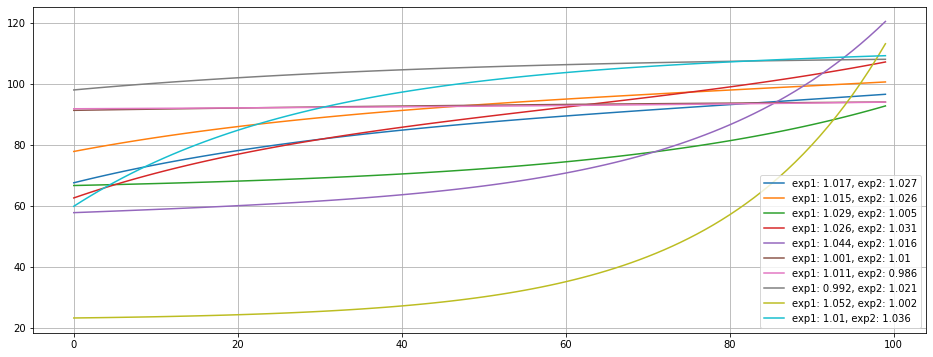

In [126]:
plt.figure(figsize=(16,6))
for i in range(10):
    exp1 = np.random.normal(1.02, 0.015)
    exp2 = np.random.normal(1.02, 0.015)
    begin = np.random.normal(50, 10)
    end = np.random.normal(100, 10)
    _ = plt.plot(create_schaled_polynomial_curve(begin, end, 100, exp1, exp2), 
        label='exp1: {}, exp2: {}'.format(round(exp1, 3), round(exp2, 3)))
plt.grid()
plt.legend()

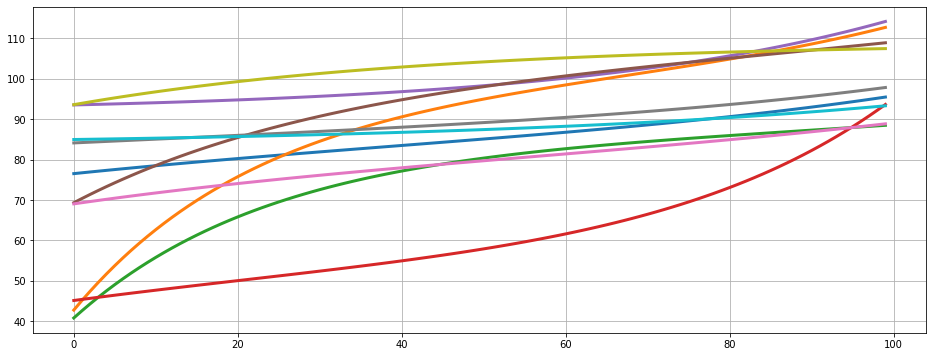

In [17]:
plt.figure(figsize=(16,6))
for i in range(10):
    exp1 = np.random.normal(1.02, 0.015)
    exp2 = np.random.normal(1.02, 0.015)
    begin = np.random.normal(50, 10)
    end = np.random.normal(100, 10)
    _ = plt.plot(create_schaled_polynomial_curve(begin, end, 100, exp1, exp2), linewidth=3)
plt.grid()

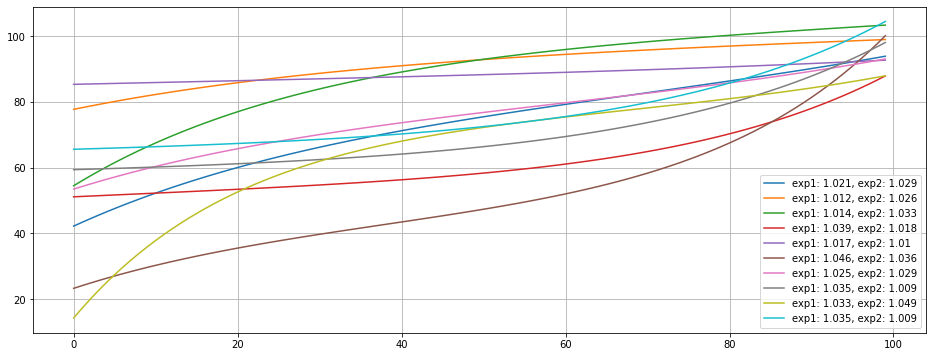

In [127]:
plt.figure(figsize=(16,6))
for i in range(10):
    exp1 = np.random.normal(1.02, 0.015)
    exp2 = np.random.normal(1.02, 0.015)
    begin = np.random.normal(50, 10)
    end = np.random.normal(100, 10)
    _ = plt.plot(create_schaled_polynomial_curve(begin, end, 100, exp1, exp2), 
        label='exp1: {}, exp2: {}'.format(round(exp1, 3), round(exp2, 3)))
plt.grid()
plt.legend()

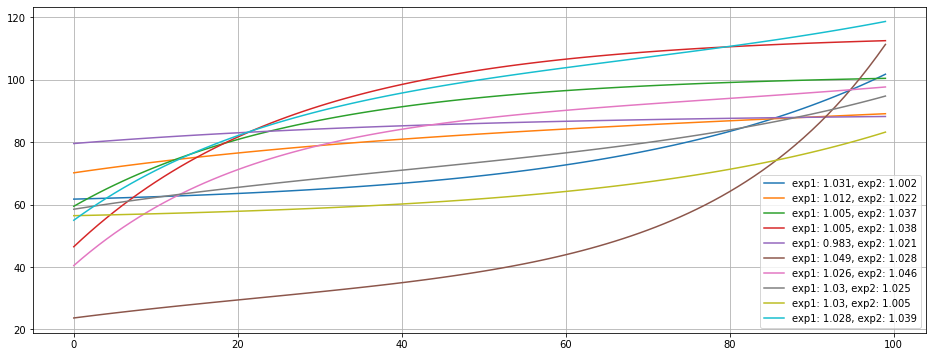

In [128]:
plt.figure(figsize=(16,6))
for i in range(10):
    exp1 = np.random.normal(1.02, 0.015)
    exp2 = np.random.normal(1.02, 0.015)
    begin = np.random.normal(50, 10)
    end = np.random.normal(100, 10)
    _ = plt.plot(create_schaled_polynomial_curve(begin, end, 100, exp1, exp2), 
        label='exp1: {}, exp2: {}'.format(round(exp1, 3), round(exp2, 3)))
plt.grid()
plt.legend()